### Project Name: House Prices
Scope: The goal is to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 


### Content
1. Gathering Data
2. EDA
3. Feature Engineering
4. Feature Selection
5. Model Building
6. Model Deployment

In [13]:
try:
    from IPython import get_ipython
    get_ipython().magic('clear')
    get_ipython().magic('reset -f')
except:
    pass

# 1. Import Libraries

In [128]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from fast_ml.feature_selection import get_duplicate_features
pd.pandas.set_option('display.max_columns', None)
import os
import pathlib
from geopy.geocoders import Nominatim
import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import itertools
from scipy.stats import chi2_contingency
from itertools import product
import scipy.stats as ss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_score
import xgboost as xg


import warnings
warnings.filterwarnings("ignore")

# 2. Functions

In [15]:
## GENERAL FUNCTIONS
# 1.1 Function for features to delete
def to_delete(df, name):
    path = r'/Users/macbookpro/Desktop/PYTHON/1. PROJECTS/1. House Prices/2. Delete/'
    # name = input('Name of the file: ')
    if type(df) == list:
        df1 = pd.DataFrame(df, columns = ['Columns'])
        df1.to_csv(path + "/" + name, header=None, index=None, sep=",", mode="w")
    else:
        df.to_csv(path + "/" + name, header=None, index=None, sep=",", mode="w")


# 1.2 Function for features to keep
def to_keep(df, name):
    path = r'/Users/macbookpro/Desktop/PYTHON/1. PROJECTS/1. House Prices/1. Keep/'
    # name = input('Name of the file: ')
    if type(df) == list:
        df1 = pd.DataFrame(df, columns = ['Columns'])
        df1.to_csv(path + "/" + name, header=None, index=None, sep=",", mode="w")
    else:
        df.to_csv(path + "/" + name, header=None, index=None, sep=",", mode="w")


# 1.3 Function for indetify if two columns have the same values
def duplicate_features(df, var1, var2):
    df_dupl = df[[var1, var2]].apply(pd.Series.value_counts)
    df_dupl['Equal'] = np.where(df_dupl[var1] == df_dupl[var2], 1,0)
    print('Columns have the same values: ', df_dupl['Equal'].sum() == df_dupl.shape[0])
    return df_dupl.head(2)


# 1.4 compute the vif for all given features
def compute_vif(considered_features):
    
    X = train[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif


# 1.5 Calculate outliers with IQR method for the whole dataframe
def calc_outliers_df(df):
    # Calculate the 1st and the 3rd quartile
    q1 = df.quantile(.25)
    q3 = df.quantile(.75)

    # Calculate interquartile range
    iqr = q3 - q1

    # Eliminate outliers from the dataset
    df1 = df[~((df < (q1 - 1.5 * iqr)) |(df > (q3 + 1.5 * iqr))).any(axis=1)]

    return df1


# 1.6 Calculate outliers with IQR method for specific feature
def calc_outliers_var(df, x):
    # Calculate the 1st and the 3rd quartile
    q1 = df[x].quantile(.25)
    q3 = df[x].quantile(.75)

    # Calculate interquartile range
    iqr = q3 - q1

    # Eliminate outliers from the dataset
    high_fence = q1 - 1.5 * iqr
    low_fence = q3 + 1.5 * iqr

    return high_fence, low_fence

# 1.7 Calculate the distribution of a value
def distribution(df, x):
    return df[x].value_counts(normalize=True).round(2).mul(100)



### GRAPHS ###
# 2.1 Boxplot
def box_plot(df, x):
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(15,5))
    plt.title('Boxplot');
    sns.boxplot(df[x]);


# 2.2 Distplot
def distplot(df, x):  
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(15,5))
    sns.distplot(df[x])

    print('Skewness of the {} is : {}'.format(x, df[x].skew()))

    plt.axvline(x = df[x].mean(), linewidth = 3, color='g', label = 'mean', alpha=.5)
    plt.axvline(x = df[x].median(), linewidth = 3, color='r', label = 'median', alpha=.5)

    plt.legend()
    plt.show()

# 2.3 Histplot
def histplot(df, x):
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(15,5))
    plt.title('Histplot');
    sns.histplot(df[x]);

# 3. Gathering Data

In [16]:
# Import training dataset
df1 = pd.read_csv(r'/Users/macbookpro/Desktop/PYTHON/1. PROJECTS/1. House Prices/house-prices-advanced-regression-techniques/train.csv')

In [17]:
# Test dataset
df2 = pd.read_csv(r'/Users/macbookpro/Desktop/PYTHON/1. PROJECTS/1. House Prices/house-prices-advanced-regression-techniques/test.csv')

In [18]:
# Sample submission
df3 = pd.read_csv(r'/Users/macbookpro/Desktop/PYTHON/1. PROJECTS/1. House Prices/house-prices-advanced-regression-techniques/sample_submission.csv')

In [19]:
# Copy datasets
train = df1.copy()
test = df2.copy()
submission = df3.copy()

## 3.1 Inspect data

In [20]:
print('Shape of the dataset: ', train.shape)
train.head()

Shape of the dataset:  (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 4. EXPLORATORY DATA ANALYSIS 
## 4.1 Univariable study
### 4.1.1 Skewness
* We'll just focus on the dependent variable ('SalePrice') and try to know a little bit more about it
* We have a very large range of possible values for target feature. Also, std is very high that means that data are not close to the mean value, in other words we expect to have a skewed dataset.
* As we expected, data of targeted variable are positively skewed. We can easily identify the positive skewness by the fact that mean is greater than median. 

In [21]:
# Statistics about target variable 
display(train['SalePrice'].describe())

print('Range of possible target values is: ', train['SalePrice'].max() - train['SalePrice'].min())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Range of possible target values is:  720100


Skeweness of the targeted variable is:  1.8828757597682129


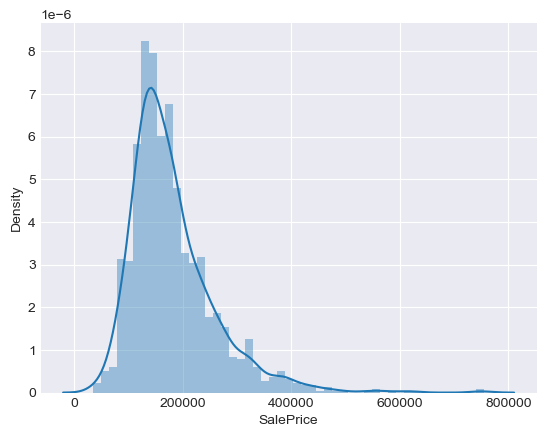

In [22]:
# Select style of the plot
plt.style.use('seaborn-darkgrid')

print('Skeweness of the targeted variable is: ', train['SalePrice'].skew())

sns.distplot(train['SalePrice'])

plt.show()

### 4.1.2 Outliers
We have the same view as above. The boxplot shows that there is right skewness and a lot of outliers exists on the rights side.  

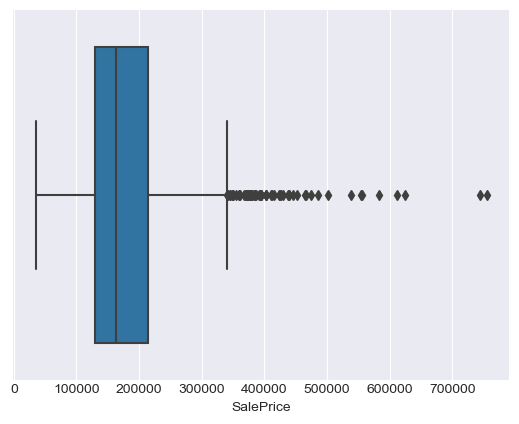

In [23]:
sns.boxplot(train['SalePrice']);

## 4.2 Multivariate Analysis
### 4.2.1 Correlation of independent variables with targeted 
* Initially, we will check the correlation between variables
* Generally we want to have high correlation between the targeted variable and the rest variables
* On the other hand, we want to have low correlation among independet variables. If the correlation among them is high we can safely remove some of them
* High correlation between independet variables leads to multi collinearity problems
* Size of correlation
    - 1-3 -> small correlation
    - 3-5 -> medium correlation
    - 5-10 -> large correlation
* After calculating the variables that have moderate and high correlation with targeted variable, then we check these variables with each other to check if exists multilinearity

In [24]:
# Check correlation among variables
corr = train.corr()

# Correlation of target variable
corr_trg = corr['SalePrice'].abs()

# Indetify high correlation of targeted variable with other variables
corr_trg_col = corr_trg[corr_trg>.3].sort_values(ascending=False).index.to_list()

corr_trg[corr_trg>.3].sort_values(ascending=False)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
Name: SalePrice, dtype: float64

In [25]:
# Check for null values
train[corr_trg_col].isna().sum()

SalePrice         0
OverallQual       0
GrLivArea         0
GarageCars        0
GarageArea        0
TotalBsmtSF       0
1stFlrSF          0
FullBath          0
TotRmsAbvGrd      0
YearBuilt         0
YearRemodAdd      0
GarageYrBlt      81
MasVnrArea        8
Fireplaces        0
BsmtFinSF1        0
LotFrontage     259
WoodDeckSF        0
2ndFlrSF          0
OpenPorchSF       0
dtype: int64

### 4.2.2 Multicollinearity - Correlation coeficient
It seems that multicollinearity exists. So, we will remove some of the independed columns that are correlated to each other in the feature engineering part 

In [26]:
# Create a dataframe with correlation of variables
mult_check = train[corr_trg_col].corr().abs().unstack().sort_values(ascending = False)
mult_check = pd.DataFrame(mult_check, columns=['cor'])

# Specify the correlation value to be greater than 0.5 and less than 1
mult_check = mult_check.loc[(mult_check['cor'] != 1) & (mult_check['cor'] > .5)]

# Remove if in the index exist the targeted variable
mult_check = mult_check.iloc[(mult_check.index.get_level_values(0) != 'SalePrice') & (mult_check.index.get_level_values(1) != 'SalePrice')]

# Drop duplicates
mult_check.drop_duplicates(subset='cor', inplace=True)

mult_check

,,cor
GarageArea,GarageCars,0.882475
YearBuilt,GarageYrBlt,0.825667
TotRmsAbvGrd,GrLivArea,0.825489
TotalBsmtSF,1stFlrSF,0.819530
GrLivArea,2ndFlrSF,0.687501
GarageYrBlt,YearRemodAdd,0.642277
GrLivArea,FullBath,0.630012
2ndFlrSF,TotRmsAbvGrd,0.616423
GarageCars,OverallQual,0.600671
GrLivArea,OverallQual,0.593007


## 4.3 Missing Values
As it is shown in the table below, I consider as significant percentage of missing values, the one for variables FireplaceQu and LotFrontage. The percentage of missing value for the rest variables is less than 5%, so we can use median or mean imputing the missing values. 

- FireplaceQu: null values can be replaced from word: No Fireplace
- LotFrontage: there is no significant correlation of the variable with other variables in order to use them for imputation, so as it shown in the distribution of the variable there is positive skewness and we will use median in order to fill missing values
- Also, we will use again median to fill missing values for the rest of the features 

In [27]:
# Create in dataframe format the prc of missing values 
prc_missing_1 = train.isnull().sum()*100/len(train)
prc_missing_1_df = pd.DataFrame(prc_missing_1, columns=['Missing values'])
prc_missing_1_df.index.name = 'Features'
prc_missing_1_df = prc_missing_1_df.reset_index()
prc_missing_1_df = prc_missing_1_df.loc[prc_missing_1_df['Missing values'] != 0].sort_values('Missing values', ascending=False)
display(prc_missing_1_df)

# Check data type
print('\n','Data Type')
prc_missing_1_df_col = prc_missing_1_df['Features'].to_list()
display(train[prc_missing_1_df_col].dtypes)

,Features,Missing values
72,PoolQC,99.520548
74,MiscFeature,96.301370
6,Alley,93.767123
73,Fence,80.753425
57,FireplaceQu,47.260274
3,LotFrontage,17.739726
58,GarageType,5.547945
59,GarageYrBlt,5.547945
60,GarageFinish,5.547945
63,GarageQual,5.547945



 Data Type


PoolQC           object
MiscFeature      object
Alley            object
Fence            object
FireplaceQu      object
LotFrontage     float64
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
BsmtExposure     object
BsmtFinType2     object
BsmtFinType1     object
BsmtCond         object
BsmtQual         object
MasVnrArea      float64
MasVnrType       object
Electrical       object
dtype: object

## 4.4 Skewness 
### 4.4.1 Skewness of Missing Values
As it is shown in the graphs below there is skewness in two variables, so we have to use the median to fill the null values.

Skeweness of the LotFrontage variable is:  2.163569142324884
Skeweness of the MasVnrArea variable is:  2.669084210182863


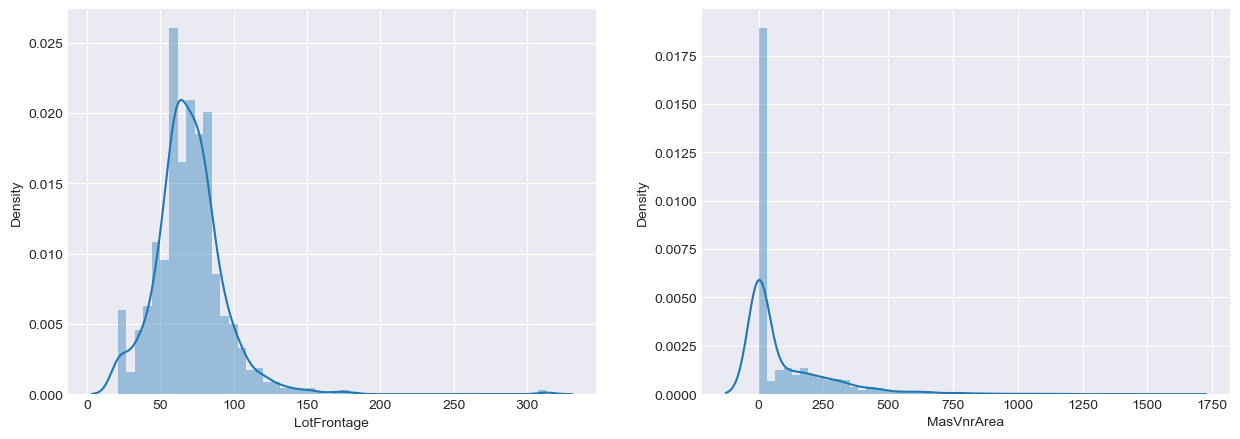

In [28]:
plt.style.use('seaborn-darkgrid')

print('Skeweness of the LotFrontage variable is: ', train['LotFrontage'].skew())
print('Skeweness of the MasVnrArea variable is: ', train['MasVnrArea'].skew())

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
sns.distplot(train['LotFrontage'], ax=ax1)

sns.distplot(train['MasVnrArea'], ax=ax2)

plt.show()

### 4.4.2 Skewness for High Correlated Feature with Targeted Feature 

In [29]:
# Get only columns with high correlation with tergeted column
col_check = ['Id','SalePrice', 'OverallQual','GrLivArea','GarageArea','TotalBsmtSF', 'FullBath','YearBuilt','YearRemodAdd',
'MasVnrArea','Fireplaces','BsmtFinSF1','LotFrontage','WoodDeckSF','2ndFlrSF','OpenPorchSF']

train_corr = train[col_check]
train_corr

,Id,SalePrice,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF
0,1,208500,7,1710,548,856,2,2003,2003,196.0,0,706,65.0,0,854,61
1,2,181500,6,1262,460,1262,2,1976,1976,0.0,1,978,80.0,298,0,0
2,3,223500,7,1786,608,920,2,2001,2002,162.0,1,486,68.0,0,866,42
3,4,140000,7,1717,642,756,1,1915,1970,0.0,1,216,60.0,0,756,35
4,5,250000,8,2198,836,1145,2,2000,2000,350.0,1,655,84.0,192,1053,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,175000,6,1647,460,953,2,1999,2000,0.0,1,0,62.0,0,694,40
1456,1457,210000,6,2073,500,1542,2,1978,1988,119.0,2,790,85.0,349,0,0
1457,1458,266500,7,2340,252,1152,2,1941,2006,0.0,2,275,66.0,0,1152,60
1458,1459,142125,5,1078,240,1078,1,1950,1996,0.0,0,49,68.0,366,0,0


In [30]:
for col in train_corr.columns:
    print('Skeweness of the {} variable is: {}'.format(col, train_corr[col].skew()))

Skeweness of the Id variable is: 0.0
Skeweness of the SalePrice variable is: 1.8828757597682129
Skeweness of the OverallQual variable is: 0.2169439277628693
Skeweness of the GrLivArea variable is: 1.3665603560164552
Skeweness of the GarageArea variable is: 0.17998090674623907
Skeweness of the TotalBsmtSF variable is: 1.5242545490627664
Skeweness of the FullBath variable is: 0.036561558402727165
Skeweness of the YearBuilt variable is: -0.613461172488183
Skeweness of the YearRemodAdd variable is: -0.5035620027004709
Skeweness of the MasVnrArea variable is: 2.669084210182863
Skeweness of the Fireplaces variable is: 0.6495651830548841
Skeweness of the BsmtFinSF1 variable is: 1.685503071910789
Skeweness of the LotFrontage variable is: 2.163569142324884
Skeweness of the WoodDeckSF variable is: 1.5413757571931312
Skeweness of the 2ndFlrSF variable is: 0.8130298163023265
Skeweness of the OpenPorchSF variable is: 2.3643417403694404


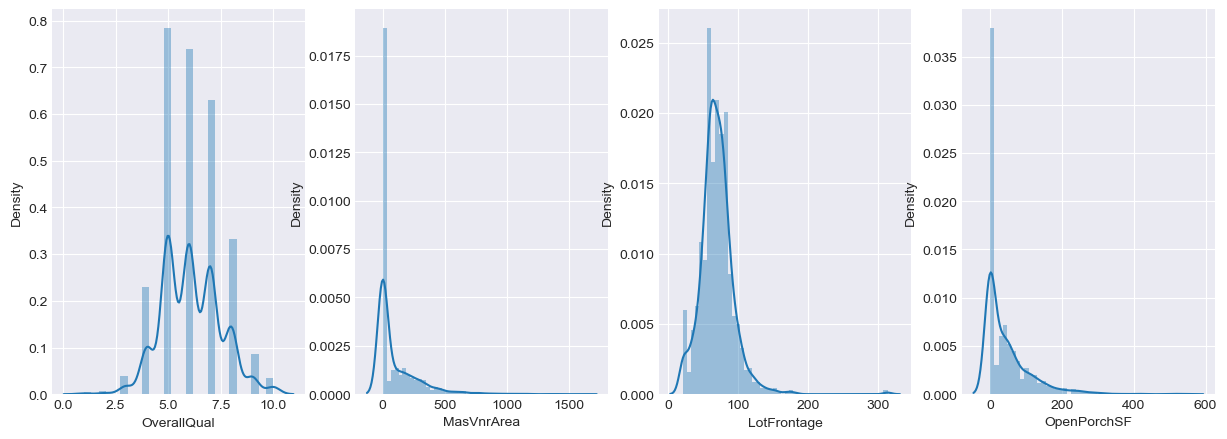

In [31]:
plt.style.use('seaborn-darkgrid')

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15,5))
sns.distplot(train['OverallQual'], ax=ax1)

sns.distplot(train['MasVnrArea'], ax=ax2)

sns.distplot(train['LotFrontage'], ax=ax3)

sns.distplot(train['OpenPorchSF'], ax=ax4)

plt.show()

### 4.4.3 Analysis of Independed Variables with Targeted Variable
1. As it is shown to the graph below, there is a linear relationship between overall quality and sale price. As the overall quality is increasing, sales prices is increasing too. 
2. It looks that there is a linear connection too. As the living area is is increasing, the price is increasing too. There are some cases where with medium range of living area the sale price is very high. Also, there are few cases of houses with very large living area that do not follow linear connection with sale price. 
3. In general, there is a linear relationship between garage area and sales price of the house. But, there are some exceptions where this reletaionship is not followed.
6. It is shown that there is not strong relationship between year of built and sale price. From years late 1880s to lates 1980s is shown that the sale price is in a specific range from aproximately 100000 to 400000. Years after 2000 the sale price of new built houses is higher than last decades. Also, from the graph above it is shown that all buildings before 1950 have been renovated. 
8. It looks that number of fireplaces is not strongly correlated with sale price of the house. The range of sale price is approximatelly the same either we ave one or two fireplaces. Also, there are few cases of houses with three fireplaces, but the sale price is not correlated.

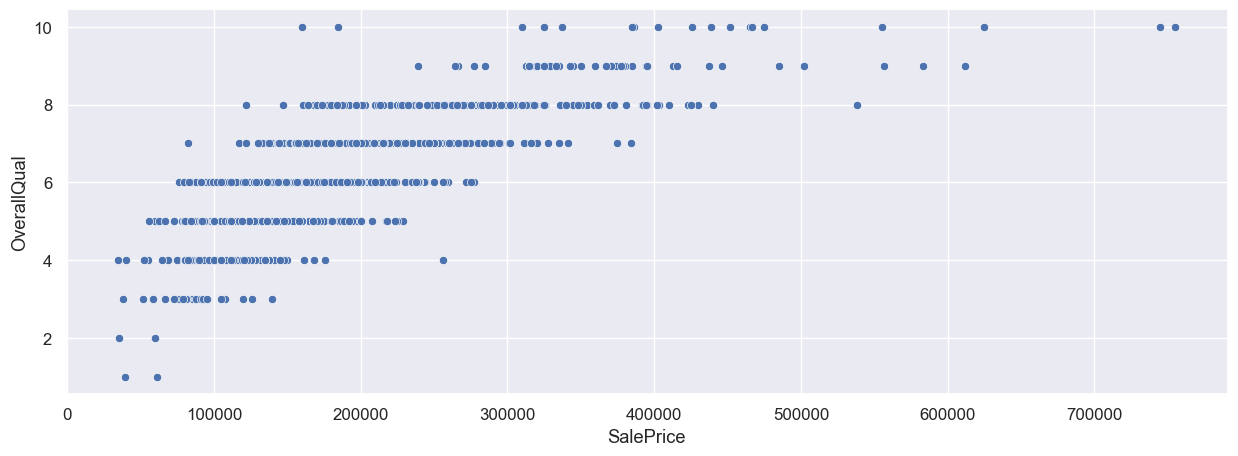

In [32]:
# 1. How the overall material quality is connected with final price of houses? 
plt.style.use('seaborn-darkgrid')

sns.set(palette="deep", font_scale=1.1, rc={"figure.figsize": [15, 5]})
sns.scatterplot(data = train, x='SalePrice', y='OverallQual')
plt.show()

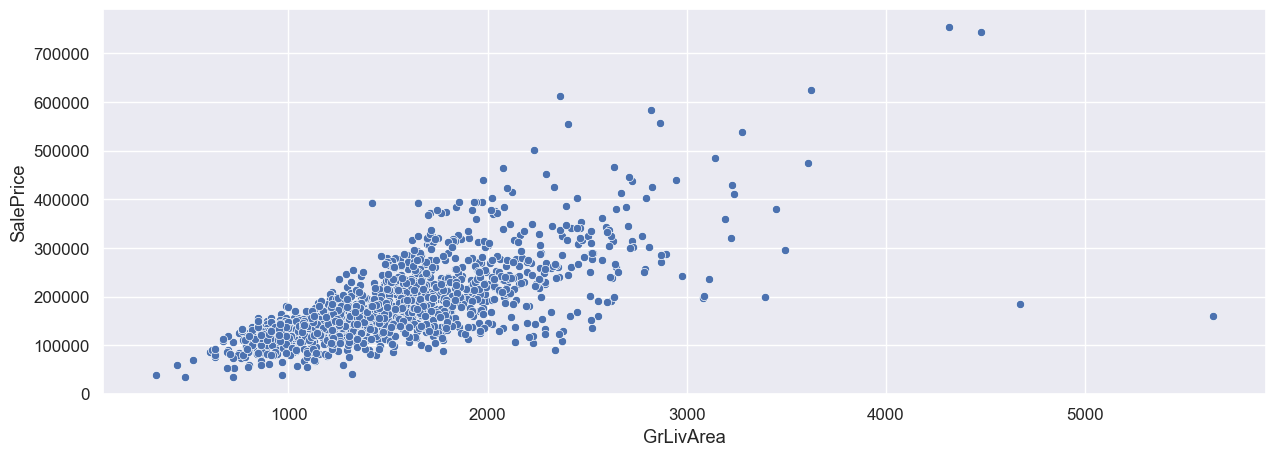

In [33]:
# 2. How the GrLivArea is connected with final price of houses? 
plt.style.use('seaborn-darkgrid')

sns.set(palette="deep", font_scale=1.1, rc={"figure.figsize": [15, 5]})
sns.scatterplot(data = train, x='GrLivArea', y='SalePrice')
plt.show()

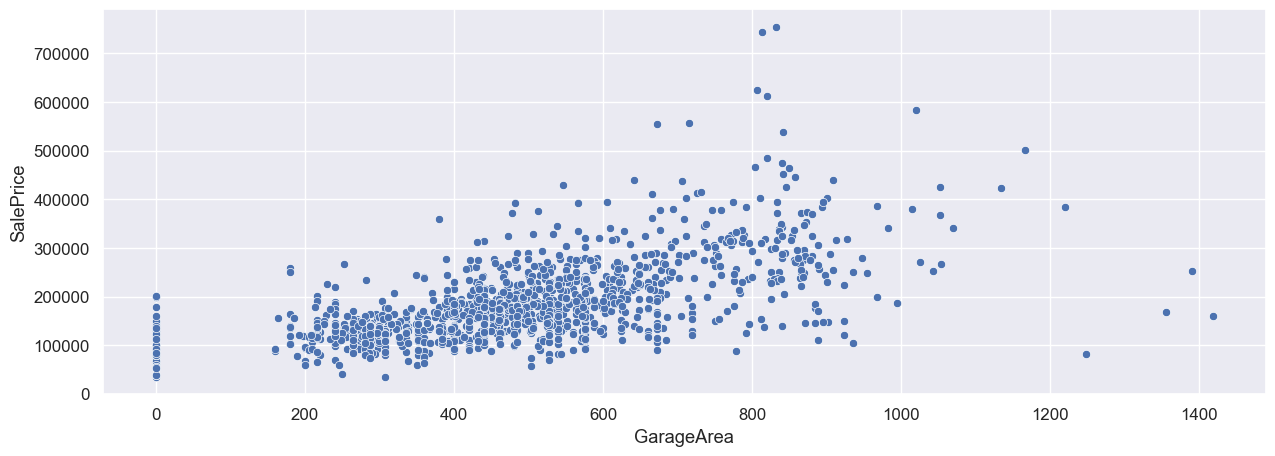

In [34]:
# 3. How the GarageArea is connected with final price of houses? 
plt.style.use('seaborn-darkgrid')

sns.set(palette="deep", font_scale=1.1, rc={"figure.figsize": [15, 5]})
sns.scatterplot(data = train, x='GarageArea', y='SalePrice')
plt.show()

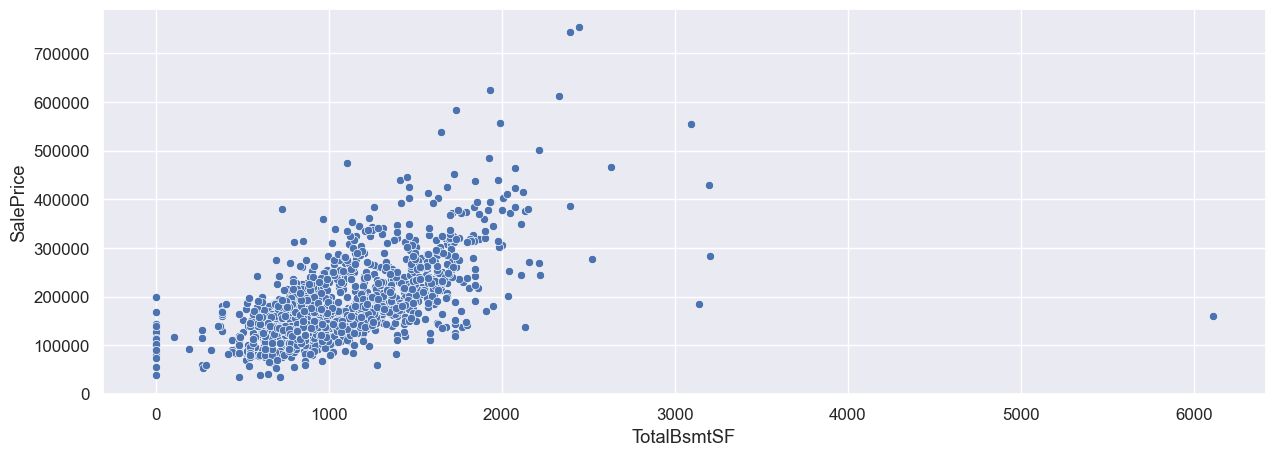

In [35]:
# 4. How the TotalBsmtSF is connected with final price of houses? 
plt.style.use('seaborn-darkgrid')

sns.set(palette="deep", font_scale=1.1, rc={"figure.figsize": [15, 5]})
sns.scatterplot(data = train, x='TotalBsmtSF', y='SalePrice')
plt.show()

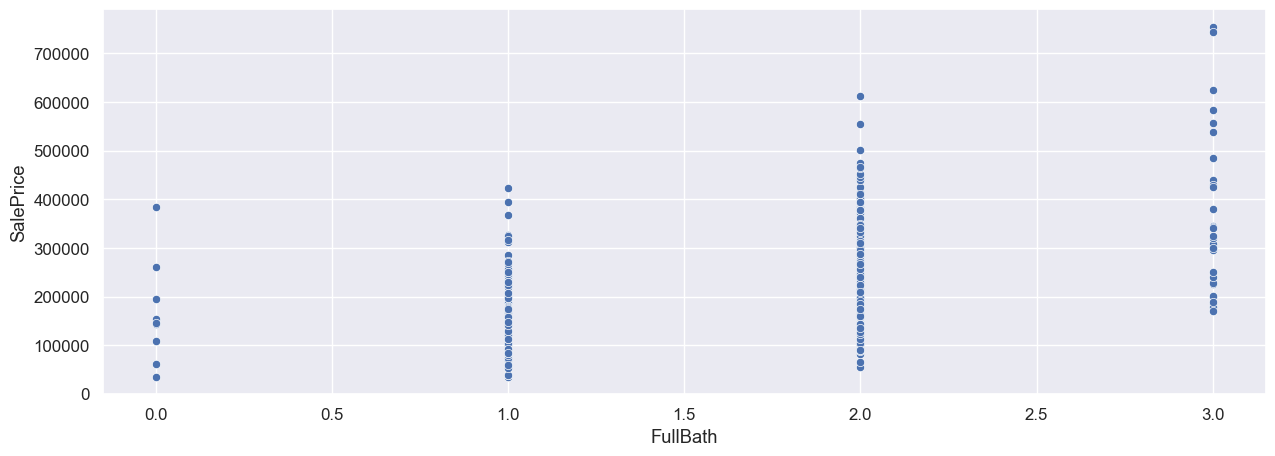

In [36]:
# 5. How the FullBath is connected with final price of houses? 
plt.style.use('seaborn-darkgrid')

sns.set(palette="deep", font_scale=1.1, rc={"figure.figsize": [15, 5]})
sns.scatterplot(data = train, x='FullBath', y='SalePrice')
plt.show()

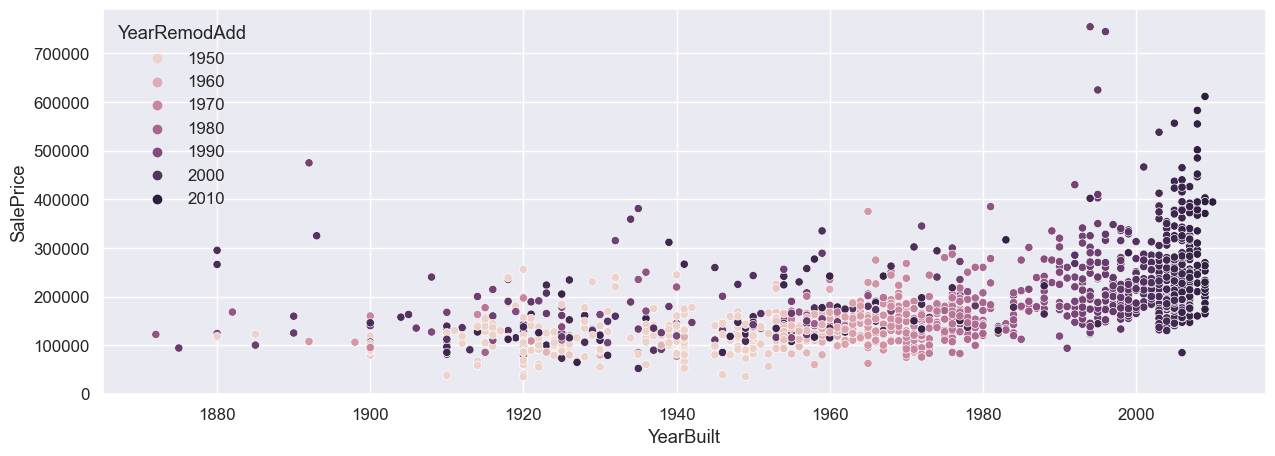

In [37]:
# 6. How the YearBuilt is connected with final price of houses? 
plt.style.use('seaborn-darkgrid')

sns.set(palette="deep", font_scale=1.1, rc={"figure.figsize": [15, 5]})
sns.scatterplot(data = train, x='YearBuilt', y='SalePrice', hue='YearRemodAdd')
plt.show()

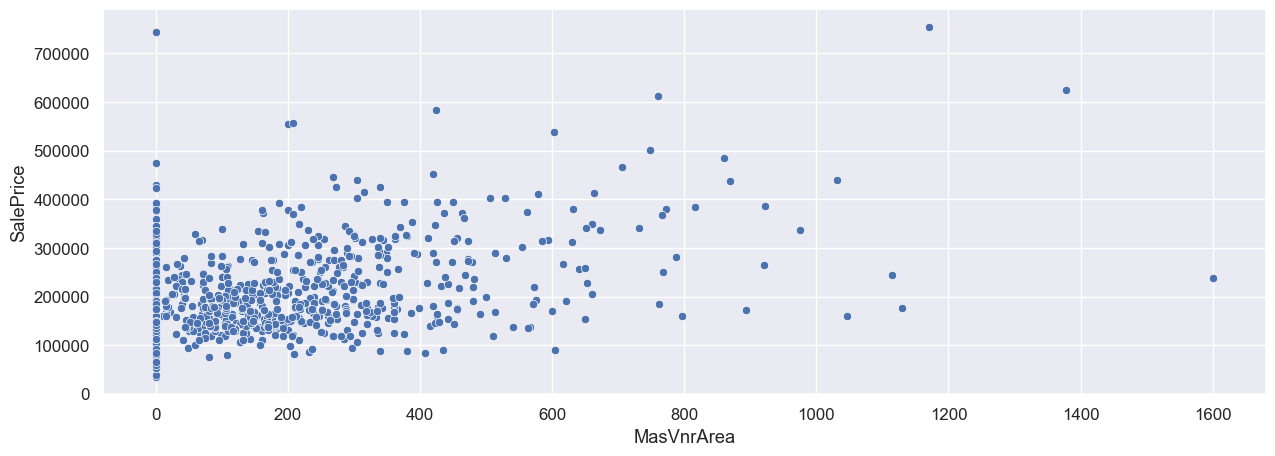

In [38]:
# 7. Correlation between MasVnrArea and sale price?
plt.style.use('seaborn-darkgrid')

sns.set(palette="deep", font_scale=1.1, rc={"figure.figsize": [15, 5]})
sns.scatterplot(data = train, x='MasVnrArea', y='SalePrice')
plt.show()

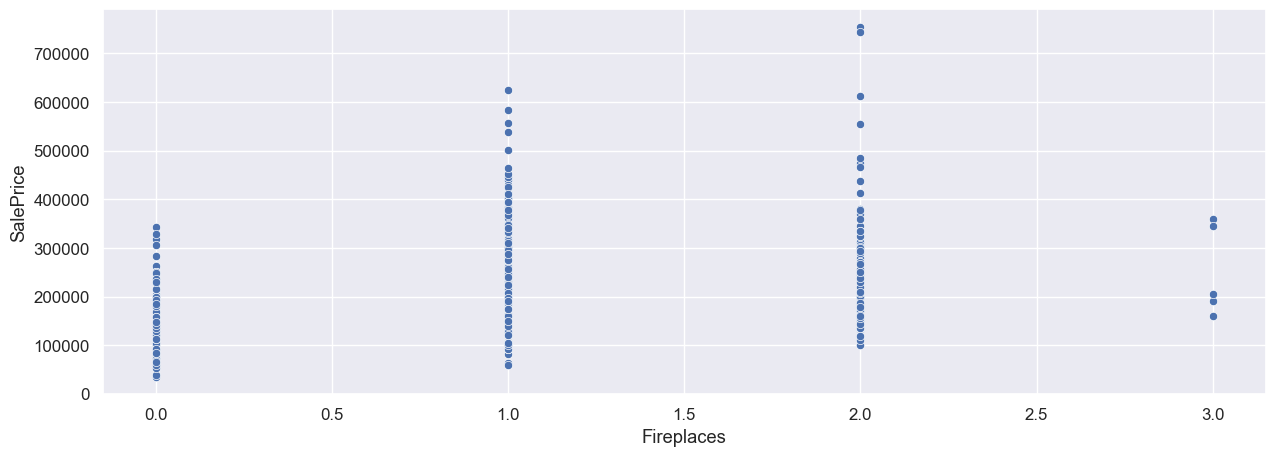

In [39]:
# 8. Does number of Fireplaces have an impact on sale price?
plt.style.use('seaborn-darkgrid')

sns.set(palette="deep", font_scale=1.1, rc={"figure.figsize": [15, 5]})
sns.scatterplot(data = train, x='Fireplaces', y='SalePrice')
plt.show()

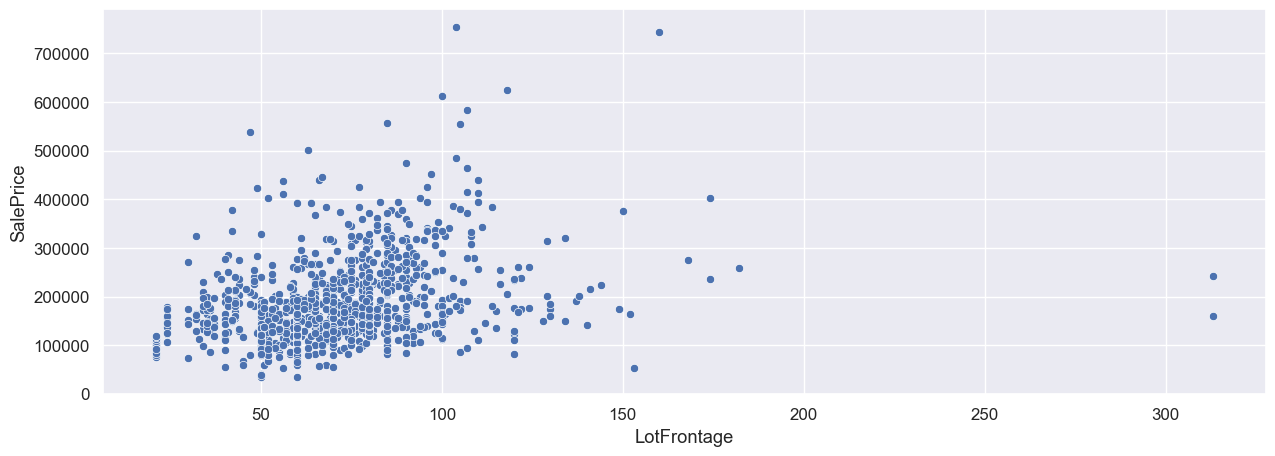

In [40]:
# 9. Association of LotFrontage with sale price?
plt.style.use('seaborn-darkgrid')

sns.set(palette="deep", font_scale=1.1, rc={"figure.figsize": [15, 5]})
sns.scatterplot(data = train, x='LotFrontage', y='SalePrice')
plt.show()

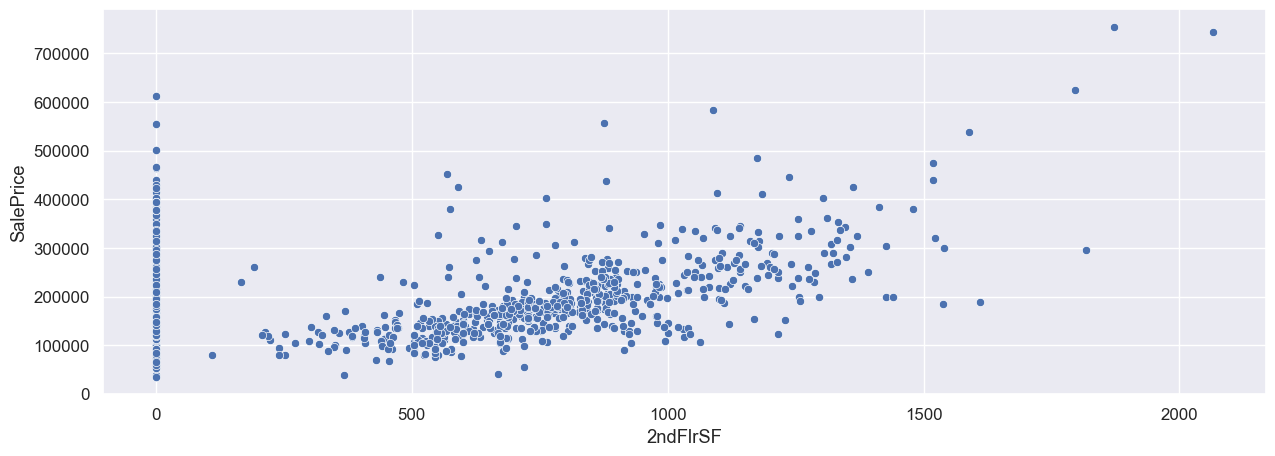

In [41]:
# 10. Association of 2ndFlrSF with sale price?
plt.style.use('seaborn-darkgrid')

sns.set(palette="deep", font_scale=1.1, rc={"figure.figsize": [15, 5]})
sns.scatterplot(data = train, x='2ndFlrSF', y='SalePrice')
plt.show()

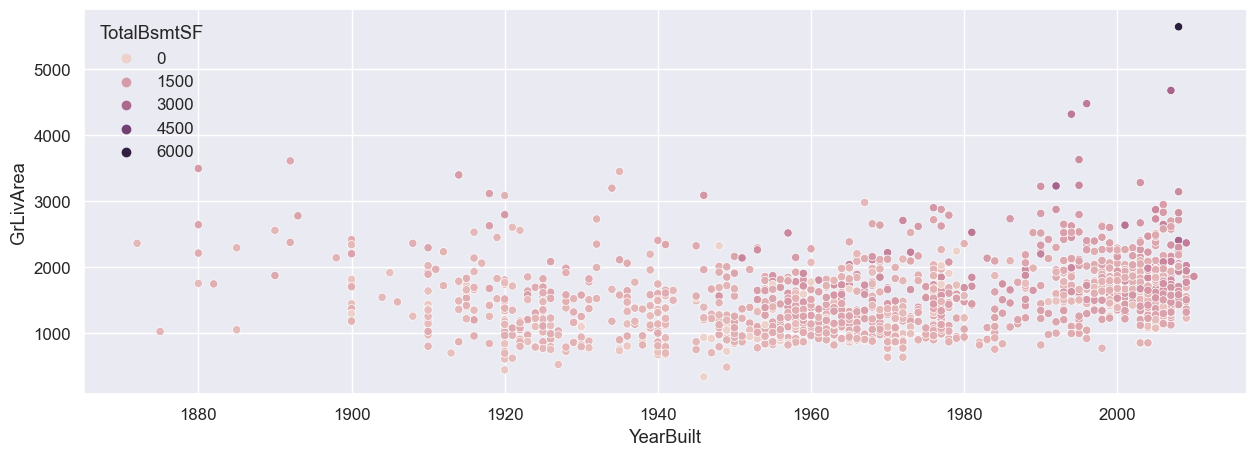

In [42]:
# 11. Is there any relationship between year of built and surface of the house
plt.style.use('seaborn-darkgrid')

sns.set(palette="deep", font_scale=1.1, rc={"figure.figsize": [15, 5]})
sns.scatterplot(data = train, x='YearBuilt', y='GrLivArea', hue='TotalBsmtSF')
plt.show()

## 4.6 Categorical Features
Select categorical variables from the initial dataset

In [43]:
# Get numeric values
cat_df = train[['Id','MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition','SalePrice']]
print('Shape of the dataset with numeric data: ', cat_df.shape)
cat_df.head()

Shape of the dataset with numeric data:  (1460, 36)


,Id,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
0,1,RL,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,WD,Normal,208500
1,2,RL,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,1Story,Gable,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,181500
2,3,RL,IR1,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,223500
3,4,RL,IR1,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,2Story,Gable,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml,140000
4,5,RL,IR1,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,250000


### 4.6.1 Categorical Features - Relationship of categorical variables with targeted variable
In order to calculate the correlation of two categorical variables we use chi-square
- Null hypothesis (H0): there is no relationship between two variables
- p-value <=0.05: reject the null hypothesis / there is relationship between two variables
- p-value > 0.05: there is no relationship between variables 

In [44]:
# Split the dataset into two parts
cat_var_1 = ['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']

cat_var_2 = ['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']

# Create all possible combinations
cat_var_comb = list(itertools.product(cat_var_1, cat_var_2, repeat=1))

cat_var_comb

[('MSZoning', 'MSZoning'),
 ('MSZoning', 'LotShape'),
 ('MSZoning', 'LandContour'),
 ('MSZoning', 'LotConfig'),
 ('MSZoning', 'LandSlope'),
 ('MSZoning', 'Neighborhood'),
 ('MSZoning', 'Condition1'),
 ('MSZoning', 'BldgType'),
 ('MSZoning', 'HouseStyle'),
 ('MSZoning', 'RoofStyle'),
 ('MSZoning', 'Exterior1st'),
 ('MSZoning', 'Exterior2nd'),
 ('MSZoning', 'MasVnrType'),
 ('MSZoning', 'ExterQual'),
 ('MSZoning', 'ExterCond'),
 ('MSZoning', 'Foundation'),
 ('MSZoning', 'BsmtQual'),
 ('MSZoning', 'BsmtCond'),
 ('MSZoning', 'BsmtExposure'),
 ('MSZoning', 'BsmtFinType1'),
 ('MSZoning', 'BsmtFinType2'),
 ('MSZoning', 'HeatingQC'),
 ('MSZoning', 'CentralAir'),
 ('MSZoning', 'Electrical'),
 ('MSZoning', 'KitchenQual'),
 ('MSZoning', 'Functional'),
 ('MSZoning', 'FireplaceQu'),
 ('MSZoning', 'GarageType'),
 ('MSZoning', 'GarageFinish'),
 ('MSZoning', 'GarageQual'),
 ('MSZoning', 'GarageCond'),
 ('MSZoning', 'PavedDrive'),
 ('MSZoning', 'SaleType'),
 ('MSZoning', 'SaleCondition'),
 ('LotShape', 

In [45]:
# Create an empty variable and picking only the p value from the output of chi-square
result = []

for i in cat_var_comb:
    if(i[0] != i[1]):
        result.append((i[0], i[1], list(ss.chi2_contingency(pd.crosstab(
            cat_df[i[0]], cat_df[i[1]]
            )))[1]))

result
# Create a table with the result
chi_2_test = pd.DataFrame(result, columns=['Var1','Var2','Coeff'])

# Create an extra colun to identify if there is relationship between pairs of variables
chi_2_test['Relationship'] = np.where(chi_2_test['Coeff']<=0.05, 1,0)

# Reshape the dataset
chi_2_test_pvt = chi_2_test.pivot(index='Var1', columns='Var2', values='Coeff')

In [46]:
cat_df

,Id,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
0,1,RL,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,WD,Normal,208500
1,2,RL,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,1Story,Gable,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,181500
2,3,RL,IR1,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,223500
3,4,RL,IR1,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,2Story,Gable,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml,140000
4,5,RL,IR1,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,RL,Reg,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,Unf,Unf,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,175000
1456,1457,RL,Reg,Lvl,Inside,Gtl,NWAmes,Norm,1Fam,1Story,Gable,Plywood,Plywood,Stone,TA,TA,CBlock,Gd,TA,No,ALQ,Rec,TA,Y,SBrkr,TA,Min1,TA,Attchd,Unf,TA,TA,Y,WD,Normal,210000
1457,1458,RL,Reg,Lvl,Inside,Gtl,Crawfor,Norm,1Fam,2Story,Gable,CemntBd,CmentBd,None,Ex,Gd,Stone,TA,Gd,No,GLQ,Unf,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal,266500
1458,1459,RL,Reg,Lvl,Inside,Gtl,NAmes,Norm,1Fam,1Story,Hip,MetalSd,MetalSd,None,TA,TA,CBlock,TA,TA,Mn,GLQ,Rec,Gd,Y,FuseA,Gd,Typ,NaN,Attchd,Unf,TA,TA,Y,WD,Normal,142125


# 5. FEATURE ENGINEERING
## 5.1 Study Targeted Variable
### 5.1.1 Missing values

In [47]:
# Copy
train_1 = train.copy()

In [48]:
# Check for null values
print('Number of null values: ', train_1['SalePrice'].isna().sum())

Number of null values:  0


### 5.1.2 Outliers
- We already know that there are outliers in our dataset and it makes our dataset skewed
- The percentage of outliers to the whole dataset is 4.2%
- We will not remove outliers even if number of outliers is only 4.2%, but we will impute them by replace extreme values with the high fence 
- By imputing outliers and check them, it seems that there are not any outliers in the targeted variable

In [49]:
print('Lower fence: ', calc_outliers_var(train_1, 'SalePrice')[0])
print('Higher fence: ', calc_outliers_var(train_1, 'SalePrice')[1])

low_fence = calc_outliers_var(train_1, 'SalePrice')[0]
high_fence = calc_outliers_var(train_1, 'SalePrice')[1]

Lower fence:  3937.5
Higher fence:  340037.5


In [50]:
print('Number of cases that are less than low fence are: ', train_1.loc[train_1['SalePrice']<low_fence].shape[0])
print('Number of cases that are more than high fence are: ', train_1.loc[train_1['SalePrice']>high_fence].shape[0])
print('The percentage of outliers to the whole dataset is: ', round((train_1.loc[train_1['SalePrice']>high_fence].shape[0]/train_1.shape[0])*100,1))

Number of cases that are less than low fence are:  0
Number of cases that are more than high fence are:  61
The percentage of outliers to the whole dataset is:  4.2


In [51]:
# Impute extreme values with high fence
train_1.loc[train_1['SalePrice']>=high_fence, 'SalePrice'] = high_fence

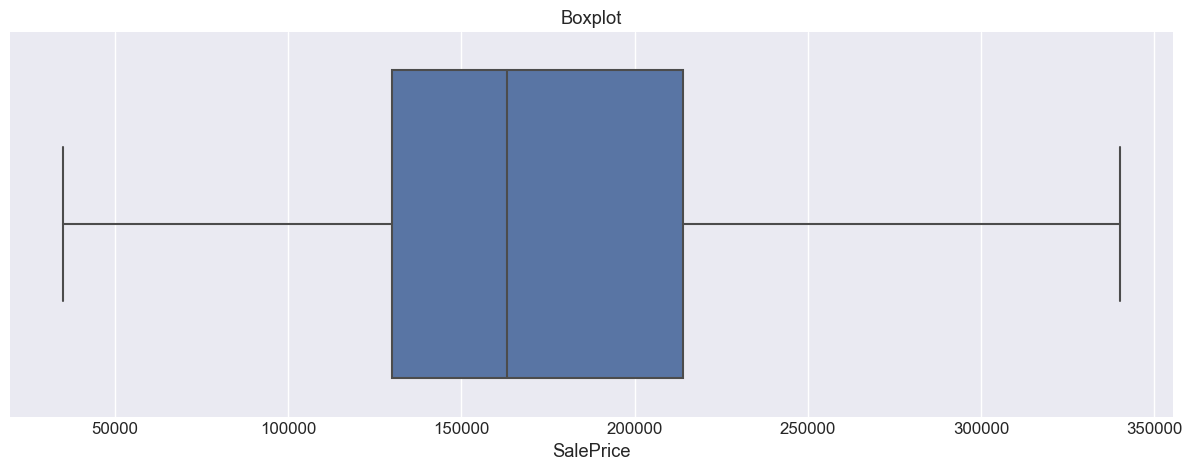

In [52]:
# Check for outliers
box_plot(train_1, 'SalePrice')

### 5.1.3 Skewness
- Even if the outliers are imputed in the previous step and there are not exist any other outliers in the targeted variable, skewness still exist (positive skewness)
- After transforming the targeted variable, the shape of the plot is more symetrical and skewness is very close to zero

Skewness of the SalePrice is : 0.8027863231337099


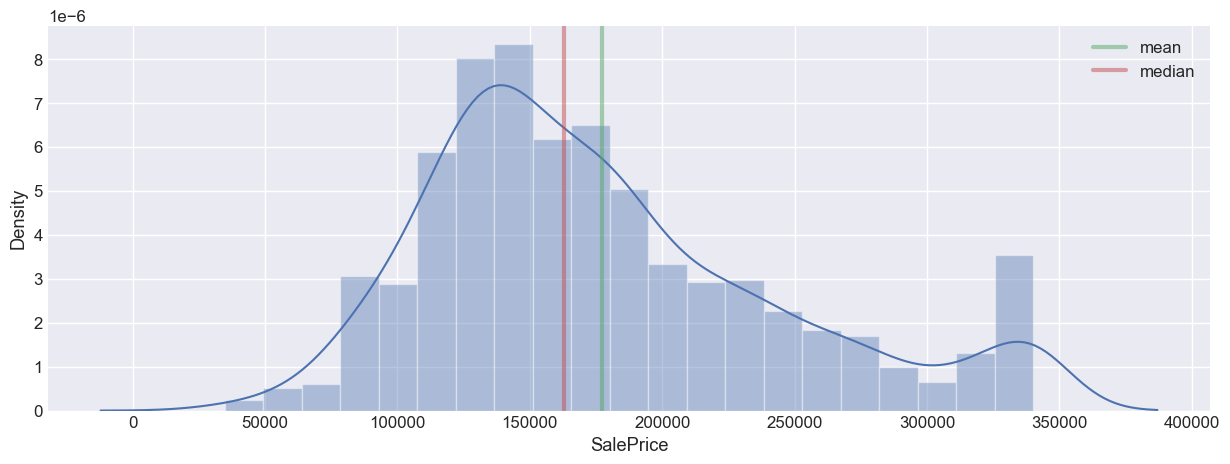

In [53]:
# Check skewness of the targeted variable
distplot(train_1,'SalePrice')

Skewness of the SalePrice is : -0.18514961386141116


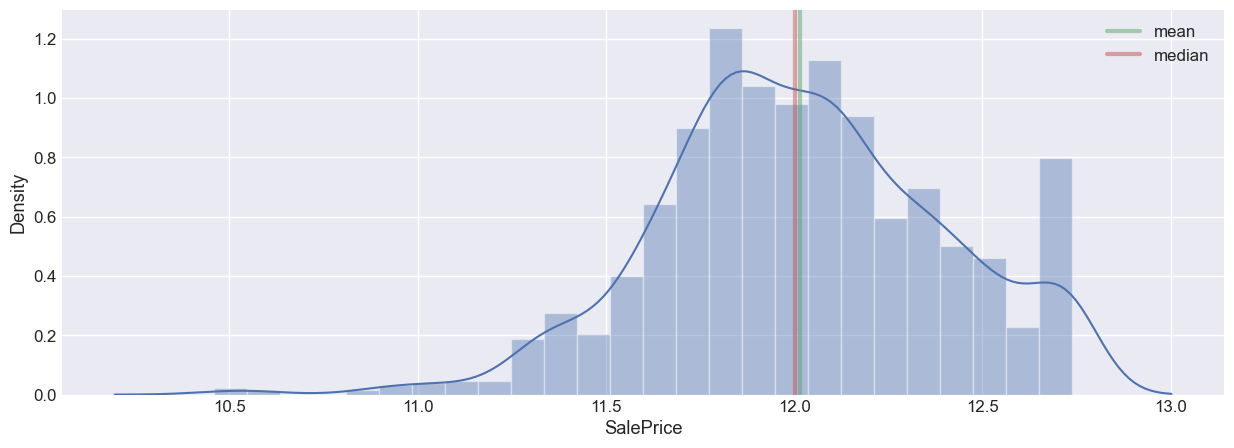

In [54]:
# We use logarithmic transformation to eliminate the skewness of the variable
train_1['SalePrice'] = np.log(train_1['SalePrice'])

# Check the skewness by plotting it
distplot(train_1, 'SalePrice')

## 5.2 Numeric Features

In [55]:
num_var = train_1[['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'SalePrice']]

print('Shape of the subset of numeric features: ', num_var.shape)
num_var.head(2)

Shape of the subset of numeric features:  (1460, 33)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
0,1,60,65.0,8450,7,5,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,12.247694
1,2,20,80.0,9600,6,8,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,12.109011


### 5.2.1 Missing values
- As we have analysed in the EDA section in more detail we will use median value to impute the missing values

In [56]:
# Percentage of missing values
prc_missing_num = num_var.isna().sum()*100/len(num_var)
missing_num = pd.DataFrame(prc_missing_num, columns=['Missing values'])
missing_num.index.name = 'Features'
missing_num = missing_num.reset_index()     

# Check Features with missing values and prc of missing values 
missing_num.loc[missing_num['Missing values']>0]

,Features,Missing values
2,LotFrontage,17.739726
6,MasVnrArea,0.547945


In [57]:
# Impute missing values by using median
train_1['LotFrontage'] = train_1['LotFrontage'].fillna(train_1['LotFrontage'].median())
train_1['MasVnrArea'] = train_1['MasVnrArea'].fillna(train_1['MasVnrArea'].median())

In [58]:
# Check if there is missing values somewhere in the dataset
print('There are missing values in the dataset: ', num_var.isna().sum().any())

There are missing values in the dataset:  True


### 5.2.2 Cardinality
* Features cardinality is not as high as we can safely drop these columns
* There are not features with low cardinality (number of unique values = 1)

In [59]:
# High or Low Feature Variability
col_1 = []

for col in num_var.columns:
    col_1.append([col, num_var[col].nunique(), len(num_var), round((num_var[col].nunique()/len(num_var))*100, 3)])

# Dataframe with statistics of columns
col_1_df = pd.DataFrame(col_1, columns=['Columns','Unique Values','Dataset Length','Percentage'])

print('Shape of the dataset: ', col_1_df.shape, '\n')
col_1_df.head()

Shape of the dataset:  (33, 4) 



,Columns,Unique Values,Dataset Length,Percentage
0,Id,1460,1460,100.000
1,MSSubClass,15,1460,1.027
2,LotFrontage,110,1460,7.534
3,LotArea,1073,1460,73.493
4,OverallQual,10,1460,0.685


In [60]:
# Check the number of features which percentage is greater than the mean
col_1_df.loc[col_1_df['Percentage']> col_1_df['Percentage'].mean()].sort_values('Percentage', ascending=True)

,Columns,Unique Values,Dataset Length,Percentage
6,MasVnrArea,327,1460,22.397
12,2ndFlrSF,417,1460,28.562
24,GarageArea,441,1460,30.205
32,SalePrice,606,1460,41.507
7,BsmtFinSF1,637,1460,43.630
10,TotalBsmtSF,721,1460,49.384
11,1stFlrSF,753,1460,51.575
9,BsmtUnfSF,780,1460,53.425
14,GrLivArea,861,1460,58.973
3,LotArea,1073,1460,73.493


In [61]:
# Check the features with low cardinality
col_1_df.loc[col_1_df['Unique Values'] == 1]

,Columns,Unique Values,Dataset Length,Percentage


### 5.2.3 Distribution of unique values
Indetify features that suck up all the variance. When 95%+ of observations fall under one value, we can safely drop as they do not provide enough variability to be meaningful.

In [62]:
# Distribution
col_2 = []
for col in num_var.columns:
    counts = num_var[col].value_counts(dropna=False, normalize=True)
    valids = counts[counts>.95].index
    if valids.notna():
        col_2.append(col)

print('Number of features is: ', len(col_2))
print('Features:')
display(col_2)

Number of features is:  5
Features:


['LowQualFinSF', 'KitchenAbvGr', '3SsnPorch', 'PoolArea', 'MiscVal']

In [63]:
# Drop unecessary features from the grand dataset
train_2 = train_1.drop(col_2, axis = 1)
print('Shape of the dataset before removing highly distributed variables is: ',train_1.shape)
print('Shape of the dataset after removing highly distributed variables is:: ', train_2.shape)

Shape of the dataset before removing highly distributed variables is:  (1460, 81)
Shape of the dataset after removing highly distributed variables is::  (1460, 76)


In [64]:
# Drop unecessary features from the subset with numeric features 
num_var_1 = num_var.drop(col_2, axis = 1)
print('Shape of the dataset before removing highly distributed variables is: ',num_var.shape)
print('Shape of the dataset after removing highly distributed variables is:: ', num_var_1.shape)

Shape of the dataset before removing highly distributed variables is:  (1460, 33)
Shape of the dataset after removing highly distributed variables is::  (1460, 28)


In [65]:
# Export drop due to distribution
name = 'Gathering_Data_Distribution.txt'
to_delete(col_2, name)

### 5.2.4 Duplicate Features
There are not duplicated features.

In [66]:
# function to detect duplicate features 
duplicate_features_1 = get_duplicate_features(num_var_1)
duplicate_features_1

,Desc,feature1,feature2


### 5.2.5 Outliers
* We keep only outliers the numeric features that are highly correlated with the targeted variable (19 vs 16)
* Due to the fact that the size of dataset is not very large, we impute outliers by replacing them with high fence variable

In [67]:
# High correlated variables with targeted variable
list1 = corr_trg[corr_trg>.3].sort_values(ascending=False).index.to_list()

# Numeric variables
list2 = num_var_1.columns.to_list()

# Sprecify the numeric variables that are highly correlated with target variable
inner_list = list(set(list1).intersection(list2))

# Remove target variable from the list
inner_list.remove('SalePrice')

print('Number of highly cerrelated variables: ', len(list1))
print('Number of highly correlated numeric variables: ', len(inner_list))

Number of highly cerrelated variables:  19
Number of highly correlated numeric variables:  15


In [68]:
# Create an empty dataframe as well as empty lists
frame = pd.DataFrame(columns=['Column','High Fence'])
high_ls = []
sthles = []

# Calculate high fence value per variable 
for col in inner_list:
    high = calc_outliers_var(num_var_1, col)[1]  
    sthles.append(col)
    high_ls.append(high)

# Add them to the dataframe 
frame['Column'] = sthles
frame['High Fence'] = high_ls

frame

,Column,High Fence
0,MasVnrArea,415.000
1,WoodDeckSF,420.000
2,FullBath,3.500
3,OverallQual,10.000
4,LotFrontage,111.500
5,TotRmsAbvGrd,10.000
6,GrLivArea,2747.625
7,GarageArea,938.250
8,TotalBsmtSF,2052.000
9,2ndFlrSF,1820.000


In [69]:
# Transpose the dataframe 
frame_T = frame.set_index('Column').transpose()
frame_T

Column,MasVnrArea,WoodDeckSF,FullBath,OverallQual,LotFrontage,TotRmsAbvGrd,GrLivArea,GarageArea,TotalBsmtSF,2ndFlrSF,BsmtFinSF1,1stFlrSF,OpenPorchSF,GarageCars,Fireplaces
High Fence,415.0,420.0,3.5,10.0,111.5,10.0,2747.625,938.25,2052.0,1820.0,1780.625,2155.125,170.0,3.5,2.5


In [70]:
# Replace outliers with high fence value 
for col in frame_T.columns.intersection(train_2.columns):
    train_2.loc[train_2[col] > frame_T.iloc[0][col], col] = frame_T.iloc[0][col]

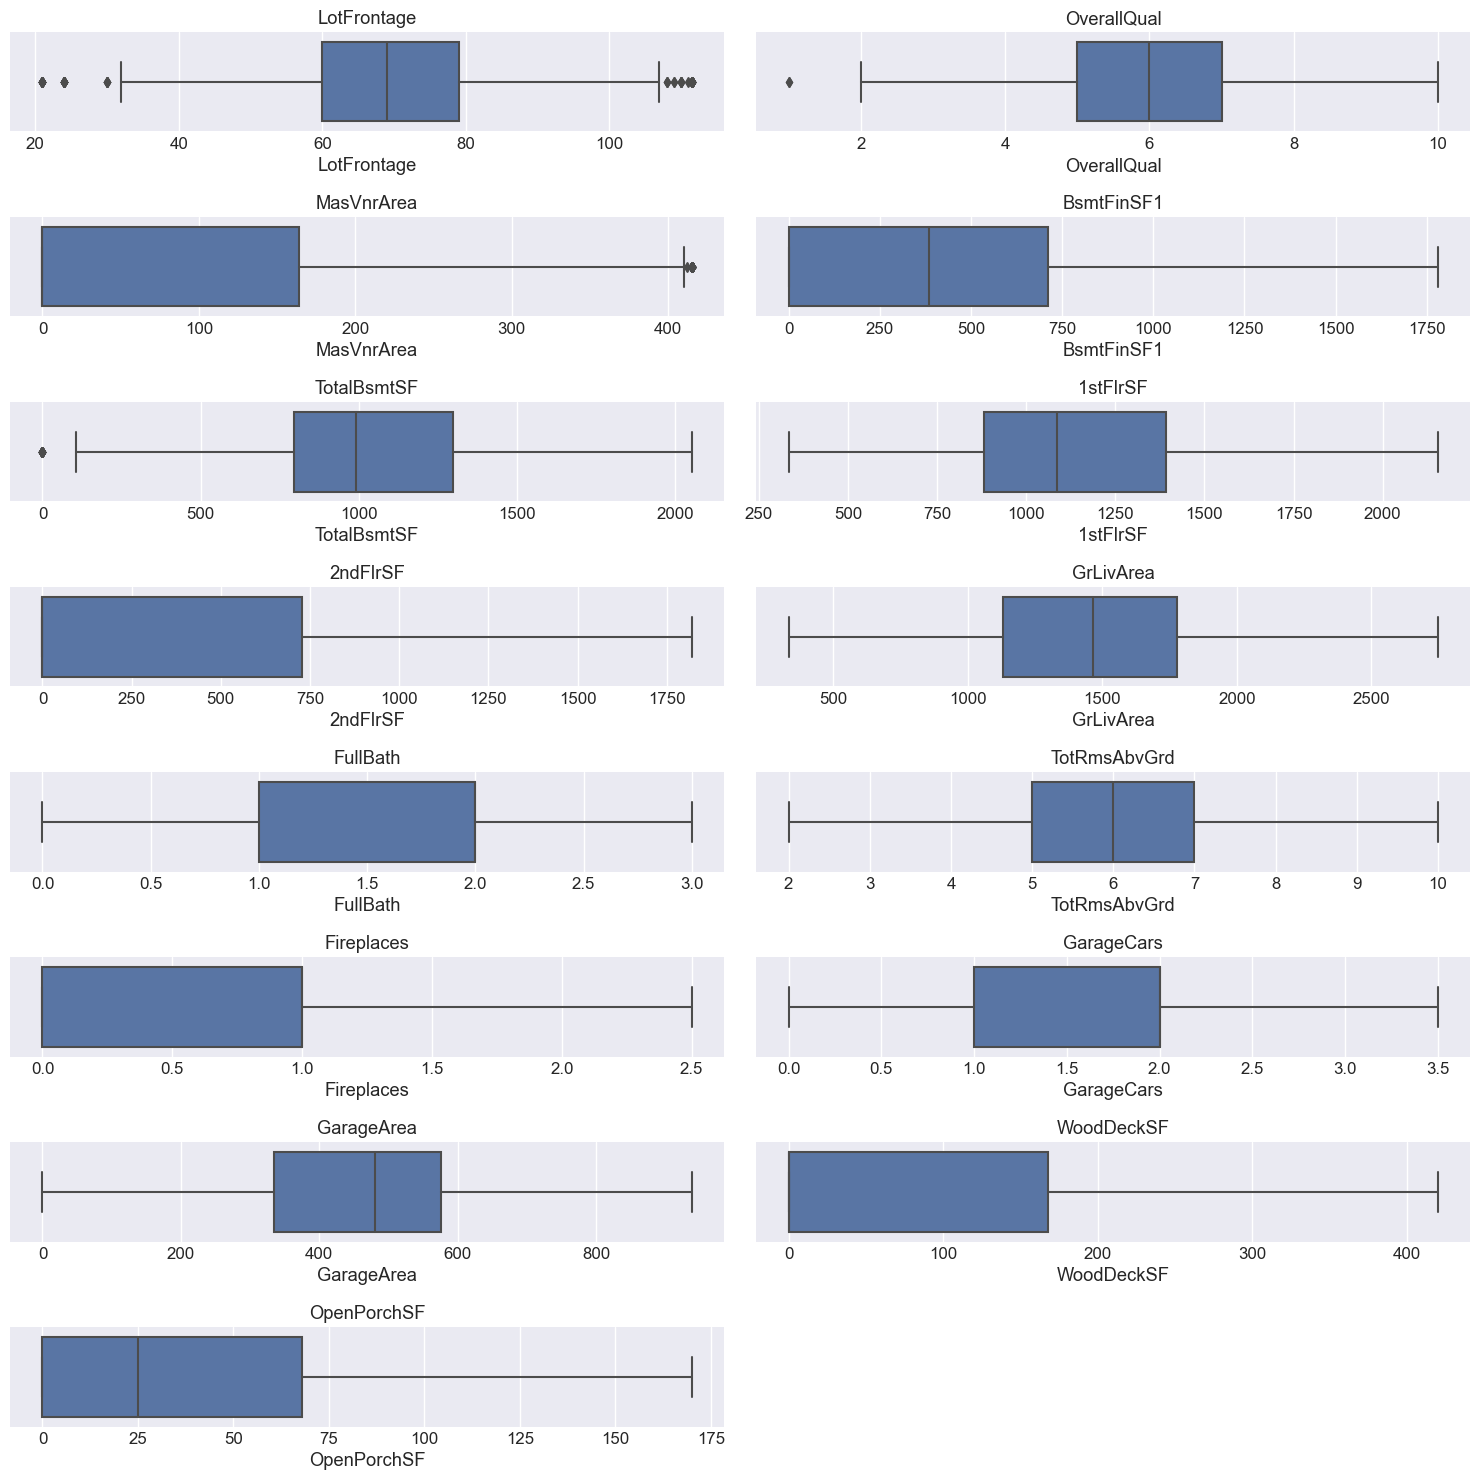

In [71]:
# Check - Plot boxplots for imputed variables  
x, y, z = 8, 2, 1

plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(15,15))

# Check imputed variables by visualize them 
for col in train_2.columns:
    if col in sthles:
        plt.subplot(x,y,z);
        plt.title('{}'.format(col));
        sns.boxplot(train_2[col]);
        z = z + 1

plt.tight_layout()
plt.show()

## 5.3 Categorical Features

In [72]:
# Copy
train_3 = train_2.copy()
print('Shape of the dataset: ', train_3.shape)
train_3.head(1)

Shape of the dataset:  (1460, 76)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0,150,856,GasA,Ex,Y,SBrkr,856.0,854,1710.0,1,0,2.0,1,3,Gd,8,Typ,0.0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,NaN,NaN,NaN,2,2008,WD,Normal,12.247694


In [73]:
# Specify the categorical features 
cat_var = train_3.select_dtypes(include='object')
cat_var.head(2)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


### 5.3.1 Missing values
* There many variables with null values
* Impute the majority of them by using the documentation

In [74]:
# Percentage of missing values
prc_missing_cat = cat_var.isna().sum()*100/len(cat_var)
missing_cat = pd.DataFrame(prc_missing_cat, columns=['Missing values'])
missing_cat.index.name = 'Features'
missing_cat = missing_cat.reset_index()  
missing_cat = missing_cat.sort_values('Missing values', ascending=False)   

# Check Features with missing values and prc of missing values 
missing_cat.loc[missing_cat['Missing values']>0]

,Features,Missing values
38,PoolQC,99.520548
40,MiscFeature,96.301370
2,Alley,93.767123
39,Fence,80.753425
32,FireplaceQu,47.260274
33,GarageType,5.547945
36,GarageCond,5.547945
35,GarageQual,5.547945
34,GarageFinish,5.547945
25,BsmtFinType2,2.602740


In [75]:
# Impute null values for categorical features - grand dataset
train_3['PoolQC'] = train_3['PoolQC'].fillna('No Pool')
train_3['MiscFeature'] = train_3['MiscFeature'].fillna('None')
train_3['Alley'] = train_3['Alley'].fillna('No alley access')
train_3['Fence'] = train_3['Fence'].fillna('No Fence')
train_3['FireplaceQu'] = train_3['FireplaceQu'].fillna('No Fireplace')
train_3['GarageType'] = train_3['GarageType'].fillna('No Garage')
train_3['GarageCond'] = train_3['GarageCond'].fillna('No Garage')
train_3['GarageQual'] = train_3['GarageQual'].fillna('No Garage')
train_3['GarageFinish'] = train_3['GarageFinish'].fillna('No Garage')
train_3['BsmtFinType2'] = train_3['BsmtFinType2'].fillna('No Basement')
train_3['BsmtExposure'] = train_3['BsmtExposure'].fillna('No Basement')
train_3['BsmtFinType1'] = train_3['BsmtFinType1'].fillna('No Basement')
train_3['BsmtQual'] = train_3['BsmtQual'].fillna('No Basement')
train_3['BsmtCond'] = train_3['BsmtCond'].fillna('No Basement')
train_3['MasVnrType'] = train_3['MasVnrType'].fillna('None')
train_3['Electrical'] = train_3['Electrical'].fillna(train_3['Electrical'].value_counts().sort_values(ascending=False).index[0])

In [76]:
# Impute null values for categorical features - subset
cat_var['PoolQC'] = cat_var['PoolQC'].fillna('No Pool')
cat_var['MiscFeature'] = cat_var['MiscFeature'].fillna('None')
cat_var['Alley'] = cat_var['Alley'].fillna('No alley access')
cat_var['Fence'] = cat_var['Fence'].fillna('No Fence')
cat_var['FireplaceQu'] = cat_var['FireplaceQu'].fillna('No Fireplace')
cat_var['GarageType'] = cat_var['GarageType'].fillna('No Garage')
cat_var['GarageCond'] = cat_var['GarageCond'].fillna('No Garage')
cat_var['GarageQual'] = cat_var['GarageQual'].fillna('No Garage')
cat_var['GarageFinish'] = cat_var['GarageFinish'].fillna('No Garage')
cat_var['BsmtFinType2'] = cat_var['BsmtFinType2'].fillna('No Basement')
cat_var['BsmtExposure'] = cat_var['BsmtExposure'].fillna('No Basement')
cat_var['BsmtFinType1'] = cat_var['BsmtFinType1'].fillna('No Basement')
cat_var['BsmtQual'] = cat_var['BsmtQual'].fillna('No Basement')
cat_var['BsmtCond'] = cat_var['BsmtCond'].fillna('No Basement')
cat_var['MasVnrType'] = cat_var['MasVnrType'].fillna('None')
cat_var['Electrical'] = cat_var['Electrical'].fillna(cat_var['Electrical'].value_counts().sort_values(ascending=False).index[0])

In [77]:
# Check if there is missing values somewhere in the dataset
print('There are missing values in the dataset: ', cat_var.isna().sum().any())

There are missing values in the dataset:  False


### 5.3.2 Cardinality
* There are not variables with only one unique value 
* There are not variables with very high cardinality

In [78]:
# High or Low Feature Variability
col_3 = []

for col in cat_var.columns:
    col_3.append([col, cat_var[col].nunique(), len(cat_var), round((cat_var[col].nunique()/len(cat_var))*100, 3)])

# Dataframe with statistics of columns
col_3_df = pd.DataFrame(col_3, columns=['Columns','Unique Values','Dataset Length','Percentage'])

print('Shape of the dataset: ', col_3_df.shape, '\n')
col_3_df.head()

Shape of the dataset:  (43, 4) 



,Columns,Unique Values,Dataset Length,Percentage
0,MSZoning,5,1460,0.342
1,Street,2,1460,0.137
2,Alley,3,1460,0.205
3,LotShape,4,1460,0.274
4,LandContour,4,1460,0.274


In [79]:
# Check the number of features which percentage is greater than the mean
col_3_df.loc[col_3_df['Percentage']> col_3_df['Percentage'].mean()].sort_values('Percentage', ascending=True)

,Columns,Unique Values,Dataset Length,Percentage
24,BsmtFinType1,7,1460,0.479
25,BsmtFinType2,7,1460,0.479
31,Functional,7,1460,0.479
33,GarageType,7,1460,0.479
10,Condition2,8,1460,0.548
12,HouseStyle,8,1460,0.548
14,RoofMatl,8,1460,0.548
9,Condition1,9,1460,0.616
41,SaleType,9,1460,0.616
15,Exterior1st,15,1460,1.027


In [80]:
# Check the features with low cardinality
col_3_df.loc[col_3_df['Unique Values'] == 1]

,Columns,Unique Values,Dataset Length,Percentage


### 5.3.3 Distribution of unique values

In [81]:
# Distribution
col_4 = []
for col in cat_var.columns:
    counts = cat_var[col].value_counts(dropna=False, normalize=True)
    valids = counts[counts>.95].index
    if valids.notna():
        col_4.append(col)

print('Number of features is: ', len(col_4))
print('Features:')
display(col_4)

Number of features is:  7
Features:


['Street',
 'Utilities',
 'Condition2',
 'RoofMatl',
 'Heating',
 'PoolQC',
 'MiscFeature']

In [82]:
# Drop unecessary features from the grand dataset
train_4 = train_3.drop(col_4, axis = 1)
print('Shape of the dataset before removing highly distributed variables is: ',train_3.shape)
print('Shape of the dataset after removing highly distributed variables is:: ', train_4.shape)

Shape of the dataset before removing highly distributed variables is:  (1460, 76)
Shape of the dataset after removing highly distributed variables is::  (1460, 69)


In [83]:
# Drop unecessary features from the subset with categorical features 
cat_var_1 = cat_var.drop(col_4, axis = 1)
print('Shape of the dataset before removing highly distributed variables is: ',cat_var.shape)
print('Shape of the dataset after removing highly distributed variables is:: ', cat_var_1.shape)

Shape of the dataset before removing highly distributed variables is:  (1460, 43)
Shape of the dataset after removing highly distributed variables is::  (1460, 36)


## 5.4 Datetime Features

In [84]:
# Copy
train_5 = train_4.copy()
print('Shape of the dataset: ', train_5.shape)
train_5.head(2)

Shape of the dataset:  (1460, 69)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,No alley access,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0,150,856,Ex,Y,SBrkr,856.0,854,1710.0,1,0,2.0,1,3,Gd,8,Typ,0.0,No Fireplace,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,No Fence,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,No alley access,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0,284,1262,Ex,Y,SBrkr,1262.0,0,1262.0,0,1,2.0,0,3,TA,6,Typ,1.0,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,No Fence,5,2007,WD,Normal,12.109011


In [85]:
# Select datetime features 
date_var = train_5[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','MoSold']]
print('Shape of the dataset: ', date_var.shape)
date_var.head()

Shape of the dataset:  (1460, 5)


,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,MoSold
0,2003,2003,2003.0,2008,2
1,1976,1976,1976.0,2007,5
2,2001,2002,2001.0,2008,9
3,1915,1970,1998.0,2006,2
4,2000,2000,2000.0,2008,12


#### 5.4.1 Missing values 

In [86]:
# Percentage of missing values
prc_missing_date = date_var.isna().sum()*100/len(date_var)
missing_date = pd.DataFrame(prc_missing_date, columns=['Missing values'])
missing_date.index.name = 'Features'
missing_date = missing_date.reset_index()  
missing_date = missing_date.sort_values('Missing values', ascending=False)   

# Check Features with missing values and prc of missing values 
missing_date.loc[missing_date['Missing values']>0]

,Features,Missing values
2,GarageYrBlt,5.547945


In [87]:
# Impute missing values
train_5['GarageYrBlt'] = train_5['GarageYrBlt'].fillna(train_5['GarageYrBlt'].median())

# Check for missing values 
train_5[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','MoSold']].isna().sum()

YearBuilt       0
YearRemodAdd    0
GarageYrBlt     0
YrSold          0
MoSold          0
dtype: int64

#### 5.4.2 Create new features 
* Create three new columns with period in years from sold year to build or renovation year
* Check if building year is the same as the building year of garage - by 3/4 the dates are equal
* Remove unecessary columns

In [88]:
# Create new columns that show the period from sold of house and year of build or year of renovation
train_5['YrSold_YearBuilt'] = train_5['YrSold'] - train_5['YearBuilt']
train_5['YrSold_YearRemodAdd'] = train_5['YrSold'] - train_5['YearRemodAdd']
train_5['YrSold_GarageYrBlt'] = train_5['YrSold'] - train_5['GarageYrBlt']

train_5[['YrSold_YearBuilt','YrSold_YearRemodAdd','YrSold_GarageYrBlt']]

,YrSold_YearBuilt,YrSold_YearRemodAdd,YrSold_GarageYrBlt
0,5,5,5.0
1,31,31,31.0
2,7,6,7.0
3,91,36,8.0
4,8,8,8.0
...,...,...,...
1455,8,7,8.0
1456,32,22,32.0
1457,69,4,69.0
1458,60,14,60.0


In [89]:
# Check if build year is equal to garage build year
train_5['Check'] = np.where(train_5['YrSold_YearBuilt'] == train_5['YrSold_GarageYrBlt'],1,0)

# Check distribution of 
round(train_5['Check'].value_counts(normalize=True),2)*100

1    75.0
0    25.0
Name: Check, dtype: float64

In [90]:
# Drop unecessary columns
train_5.drop(columns=['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','MoSold','Check'], axis=1, inplace=True)

In [91]:
# Check for missing values
train_5.isna().sum().any()

False

## 5.5 Feature Scaling

In [92]:
# Copy
train_6 = train_5.copy()
print('Shape of the dataset: ', train_6.shape)
train_6.head(1)

Shape of the dataset:  (1460, 67)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,SaleType,SaleCondition,SalePrice,YrSold_YearBuilt,YrSold_YearRemodAdd,YrSold_GarageYrBlt
0,1,60,RL,65.0,8450,No alley access,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0,150,856,Ex,Y,SBrkr,856.0,854,1710.0,1,0,2.0,1,3,Gd,8,Typ,0.0,No Fireplace,Attchd,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,No Fence,WD,Normal,12.247694,5,5,5.0


### 5.5.1 Feature Scaling - Grouping of Categorical Features
* Where it is possible grouping the possible values of categorical features 

In [93]:
# LotShape
train_6['LotShape'] = np.where(train_6['LotShape'].str.contains('IR'), 'IR', train_6['LotShape'])

# Alley
train_6['Alley'] = np.where(train_6['Alley'] != 'No alley access', 'Alley access', train_6['Alley'])

# LandContour
train_6['LandContour'] = np.where(train_6['LandContour'] != 'Lvl', 'Non Flatness', train_6['LandContour'])

# Condition1
train_6.loc[((train_6['Condition1'] == 'RRNn') | (train_6['Condition1'] == 'RRNe')), 'Condition1'] = 'Within_200_Railroad'
train_6.loc[((train_6['Condition1'] == 'RRAn') | (train_6['Condition1'] == 'RRAe')), 'Condition1'] = 'Adjacent_to_Railroad'
train_6.loc[((train_6['Condition1'] == 'Artery') | (train_6['Condition1'] == 'Feedr')), 'Condition1'] = 'Adjacent_to_arterial_feeder_street'
train_6.loc[((train_6['Condition1'] == 'PosN') | (train_6['Condition1'] == 'PosA')), 'Condition1'] = 'Positive_Feature'

# Exterior1st
train_6.loc[((train_6['Exterior1st'] == 'Wd Sdng') | (train_6['Exterior1st'] == 'WdShing')), 'Exterior1st'] = 'Wood'
train_6.loc[((train_6['Exterior1st'] == 'AsbShng') | (train_6['Exterior1st'] == 'AsphShn')), 'Exterior1st'] = 'Shingles'
train_6.loc[((train_6['Exterior1st'] == 'ImStucc') | (train_6['Exterior1st'] == 'Stucco')), 'Exterior1st'] = 'Stucco' 

# Exterior2nd
train_6.loc[((train_6['Exterior2nd'] == 'Wd Sdng') | (train_6['Exterior2nd'] == 'WdShing')), 'Exterior2nd'] = 'Wood'
train_6.loc[((train_6['Exterior2nd'] == 'AsbShng') | (train_6['Exterior2nd'] == 'AsphShn')), 'Exterior2nd'] = 'Shingles'
train_6.loc[((train_6['Exterior2nd'] == 'ImStucc') | (train_6['Exterior2nd'] == 'Stucco')), 'Exterior2nd'] = 'Stucco' 

# MasVnrType
train_6.loc[((train_6['MasVnrType'] == 'BrkFace') | (train_6['MasVnrType'] == 'BrkCmn')), 'MasVnrType'] = 'Brick'

# BsmtFinType1
train_6.loc[((train_6['BsmtFinType1'] == 'ALQ') | (train_6['BsmtFinType1'] == 'BLQ') | (train_6['BsmtFinType1'] == 'Rec')), 'BsmtFinType1'] = 'Average'

# BsmtFinType2
train_6.loc[((train_6['BsmtFinType2'] == 'ALQ') | (train_6['BsmtFinType2'] == 'BLQ') | (train_6['BsmtFinType2'] == 'Rec')), 'BsmtFinType2'] = 'Average'

# Functional
train_6.loc[((train_6['Functional'] == 'Min1') | (train_6['Functional'] == 'Min2')), 'Functional'] = 'Minor Deductions'
train_6.loc[((train_6['Functional'] == 'Maj1') | (train_6['Functional'] == 'Maj2')), 'Functional'] = 'Major Deductions'

# SaleType
train_6.loc[((train_6['SaleType'] == 'WD') | (train_6['SaleType'] == 'CWD') | (train_6['SaleType'] == 'VWD')), 'SaleType'] = 'Warranty'
train_6.loc[((train_6['SaleType'] == 'Con') | (train_6['SaleType'] == 'ConLw') | (train_6['SaleType'] == 'ConLI') | (train_6['SaleType'] == 'ConLD')), 'SaleType'] = 'Contract'


In [94]:
# Check for missing values
train_6.isna().sum().any()

False

### 5.5.2 Feature Scaling - Numeric Features 
* As we have already take care about distribution of numeric columns to have a norml distribution, we use standardization as scaling method

In [95]:
# Function for scaling
def scale_condition(x):
    if x == "No Garage":
        return 1
    elif x == "Po":
        return 2
    elif x == "Fa":
        return 3
    elif x == 'TA':
        return 4
    elif x == 'Gd':
        return 5
    elif x == 'Ex':
        return 6

# Scale 
train_6["GarageCond"] = train_6["GarageCond"].apply(scale_condition)
train_6["GarageQual"] = train_6["GarageQual"].apply(scale_condition)

In [96]:
# Function for scaling
def scale_condition(x):
    if x == "Fa":
        return 1
    elif x == "TA":
        return 2
    elif x == "Gd":
        return 3
    elif x == 'Ex':
        return 4

# Scale 
train_6["KitchenQual"] = train_6["KitchenQual"].apply(scale_condition)
train_6["ExterQual"] = train_6["ExterQual"].apply(scale_condition)

In [97]:
# Function for scaling
def scale_condition(x):
    if x == "Po":
        return 1
    elif x == "Fa":
        return 2
    elif x == 'TA':
        return 3
    elif x == 'Gd':
        return 4
    elif x == 'Ex':
        return 5

# Scale 
train_6["ExterCond"] = train_6["ExterCond"].apply(scale_condition)
train_6["HeatingQC"] = train_6["HeatingQC"].apply(scale_condition)

In [98]:
# Function for scaling
def scale_condition(x):
    if x == "No Basement":
        return 1
    elif x == "Po":
        return 2
    elif x == 'Fa':
        return 3
    elif x == 'TA':
        return 4
    elif x == 'Gd':
        return 5

# Scale 
train_6["BsmtCond"] = train_6["BsmtCond"].apply(scale_condition)

In [99]:
# Function for scaling
def scale_condition(x):
    if x == "No Basement":
        return 1
    elif x == "Fa":
        return 2
    elif x == 'TA':
        return 3
    elif x == 'Gd':
        return 4
    elif x == 'Ex':
        return 5

# Scale 
train_6["BsmtQual"] = train_6["BsmtQual"].apply(scale_condition)

In [100]:
# Function for scaling
def scale_condition(x):
    if x == "No Fireplace":
        return 1
    elif x == "Po":
        return 2
    elif x == "Fa":
        return 3
    elif x == 'TA':
        return 4
    elif x == 'Gd':
        return 5
    elif x == 'Ex':
        return 6

# Scale 
train_6["FireplaceQu"] = train_6["FireplaceQu"].apply(scale_condition)

In [101]:
# Select the numeric features for scaling 
num_columns = train_6.select_dtypes(exclude='object').columns
num_columns_1 = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ScreenPorch', 'SalePrice', 'YrSold_YearBuilt',
       'YrSold_YearRemodAdd', 'YrSold_GarageYrBlt']

train_6[num_columns_1].head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SalePrice,YrSold_YearBuilt,YrSold_YearRemodAdd,YrSold_GarageYrBlt
0,60,65.0,8450,7,5,196.0,3,3,4,4,706.0,0,150,856,5,856.0,854,1710.0,1,0,2.0,1,3,3,8,0.0,1,2.0,548.0,4,4,0,61,0,0,12.247694,5,5,5.0
1,20,80.0,9600,6,8,0.0,2,3,4,4,978.0,0,284,1262,5,1262.0,0,1262.0,0,1,2.0,0,3,2,6,1.0,4,2.0,460.0,4,4,298,0,0,0,12.109011,31,31,31.0
2,60,68.0,11250,7,5,162.0,3,3,4,4,486.0,0,434,920,5,920.0,866,1786.0,1,0,2.0,1,3,3,6,1.0,4,2.0,608.0,4,4,0,42,0,0,12.317167,7,6,7.0
3,70,60.0,9550,7,5,0.0,2,3,3,5,216.0,0,540,756,4,961.0,756,1717.0,1,0,1.0,0,3,3,7,1.0,5,3.0,642.0,4,4,0,35,272,0,11.849398,91,36,8.0
4,60,84.0,14260,8,5,350.0,3,3,4,4,655.0,0,490,1145,5,1145.0,1053,2198.0,1,0,2.0,1,4,3,9,1.0,4,3.0,836.0,4,4,192,84,0,0,12.429216,8,8,8.0


In [102]:
# Create the scaler
scaler = StandardScaler()

# Fit the scaler to the columns
scaler.fit(train_6[num_columns_1])

# Transform the columns
train_6[num_columns_1] = scaler.transform(train_6[num_columns_1])

train_6.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,SaleType,SaleCondition,SalePrice,YrSold_YearBuilt,YrSold_YearRemodAdd,YrSold_GarageYrBlt
0,1,0.073375,RL,-0.217871,-0.207142,No alley access,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,0.651479,-0.517200,Gable,VinylSd,VinylSd,Brick,0.789332,1.052302,-0.238112,PConc,0.618960,0.117884,No,GLQ,0.614224,Unf,-0.288653,-0.944591,-0.482319,0.891179,Y,SBrkr,-0.830489,1.164283,0.428636,1.107810,-0.241061,0.789741,1.227585,0.163779,0.735994,0.981148,Typ,-0.957043,-1.008334,Attchd,RFn,0.315946,0.373509,0.262542,0.265618,Y,-0.787243,0.350520,-0.359325,-0.270208,No Fence,Warranty,Normal,0.612476,-1.043259,-0.869941,-1.008328
1,2,-0.872563,RL,0.606769,-0.091886,No alley access,Reg,Lvl,FR2,Gtl,Veenker,Adjacent_to_arterial_feeder_street,1Fam,1Story,-0.071836,2.179628,Gable,MetalSd,MetalSd,None,-0.666040,-0.689604,-0.238112,CBlock,0.618960,0.117884,Gd,Average,1.242296,Unf,-0.288653,-0.641228,0.531301,0.891179,Y,SBrkr,0.289638,-0.796041,-0.502349,-0.819964,3.948809,0.789741,-0.761621,0.163779,-0.771091,-0.316385,Typ,0.608540,0.648890,Attchd,RFn,0.315946,-0.051541,0.262542,0.265618,Y,1.768105,-0.811747,-0.359325,-0.270208,No Fence,Warranty,Normal,0.246843,-0.183465,0.390141,0.073805
2,3,0.073375,RL,-0.052943,0.073480,No alley access,IR,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,0.651479,-0.517200,Gable,VinylSd,VinylSd,Brick,0.536870,1.052302,-0.238112,PConc,0.618960,0.117884,Mn,GLQ,0.106224,Unf,-0.288653,-0.301643,-0.322537,0.891179,Y,SBrkr,-0.653917,1.191828,0.586571,1.107810,-0.241061,0.789741,1.227585,0.163779,0.735994,-0.316385,Typ,0.608540,0.648890,Attchd,RFn,0.315946,0.663315,0.262542,0.265618,Y,-0.787243,-0.011497,-0.359325,-0.270208,No Fence,Warranty,Normal,0.795638,-0.977121,-0.821476,-0.925087
3,4,0.309859,RL,-0.492750,-0.096897,No alley access,IR,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,2Story,0.651479,-0.517200,Gable,Wood,Wd Shng,None,-0.666040,-0.689604,-0.238112,BrkTil,-0.655627,1.929579,No,Average,-0.517230,Unf,-0.288653,-0.061670,-0.731979,-0.151386,Y,SBrkr,-0.540801,0.939328,0.443182,1.107810,-0.241061,-1.026041,-0.761621,0.163779,0.735994,0.332382,Typ,0.608540,1.201298,Detchd,Unf,1.662750,0.827539,0.262542,0.265618,Y,-0.787243,-0.144872,4.092524,-0.270208,No Fence,Warranty,Abnorml,-0.437616,1.800676,0.632464,-0.883467
4,5,0.073375,RL,0.826673,0.375148,No alley access,IR,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,2Story,1.374795,-0.517200,Gable,VinylSd,VinylSd,Brick,1.932839,1.052302,-0.238112,PConc,0.618960,0.117884,Av,GLQ,0.496460,Unf,-0.288653,-0.174865,0.239198,0.891179,Y,SBrkr,-0.033157,1.621080,1.442744,1.107810,-0.241061,0.789741,1.227585,1.390023,0.735994,1.629914,Typ,0.608540,0.648890,Attchd,RFn,1.662750,1.764579,0.262542,0.265618,Y,0.859156,0.788753,-0.359325,-0.270208,No Fence,Warranty,Normal,1.091052,-0.944052,-0.724547,-0.883467


### 5.5.3 Feature Scaling - Categorical Features
* Use one-hot encoding for categorical features

In [103]:
train_6 = pd.get_dummies(train_6, columns=['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'CentralAir',
       'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive',
       'Fence', 'SaleType', 'SaleCondition'])

train_6

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SalePrice,YrSold_YearBuilt,YrSold_YearRemodAdd,YrSold_GarageYrBlt,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Alley access,Alley_No alley access,LotShape_IR,LotShape_Reg,LandContour_Lvl,LandContour_Non Flatness,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Adjacent_to_Railroad,Condition1_Adjacent_to_arterial_feeder_street,Condition1_Norm,Condition1_Positive_Feature,Condition1_Within_200_Railroad,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Shingles,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wood,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Shingles,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Shng,Exterior2nd_Wood,MasVnrType_Brick,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_No Basement,BsmtFinType1_Average,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_No Basement,BsmtFinType1_Unf,BsmtFinType2_Average,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_No Basement,BsmtFinType2_Unf,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Major Deductions,Functional_Minor Deductions,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No Garage,GarageFinish_Fin,GarageFinish_No Garage,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_No Fence,SaleType_COD,SaleType_Contract,SaleType_New,SaleType_Oth,SaleType_Warranty,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,0.073375,-0.217871,-0.207142,0.651479,-0.517200,0.789332,1.052302,-0.238112,0.618960,0.117884,0.614224,-0.288653,-0.944591,-0.482319,0.891179,-0.830489,1.164283,0.428636,1.107810,-0.241061,0.789741,1.227585,0.163779,0.735994,0.981148,-0.957043,-1.008334,0.315946,0.373509,0.262542,0.265618,-0.787243,0.350520,-0.359325,-0.270208,0.612476,-1.043259,-0.869941,-1.008328,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1

In [104]:
# Check for missing values
train_6.isna().sum().any()

False

# 6. MODEL BUILDING
The Linear Regression model has a lower mean RMSE (0.3227) than the Random Forest Regressor model (0.5880). This suggests that, on average, the Linear Regression model's predictions are closer to the actual values, indicating better performance in terms of RMSE.

Additionally, the higher standard deviation for the Linear Regression model (0.0289) indicates higher variability compared to the Random Forest model (0.0187).

In [105]:
# Copy
train_7 = train_6.copy()

In [106]:
# Independent - dependent variables
x, y = train_7.drop(['SalePrice'], axis=1), train_7['SalePrice']  

# Check 
print('Shape of the independent variables: ', x.shape)
print('Shape of the dependent variable: ', y.shape)

Shape of the independent variables:  (1460, 199)
Shape of the dependent variable:  (1460,)


In [129]:
# Assigne the linear regression function to a variable
lr = LinearRegression()

# Assign the random forest function to a variable
rf = RandomForestRegressor(max_depth=2, random_state=42)

# Create a list of models
models = [lr, rf]

# Set the number of folds
n_splits = 5

# Initialize the Stratified KFold
kf = KFold(n_splits=n_splits)

# Evaluate each model
for model in models:
    mse_scores = cross_val_score(model, x, y, cv=kf, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-mse_scores)  # Calculate RMSE from MSE
    print(f"Model {model.__class__.__name__} - Mean RMSE: {rmse_scores.mean():.4f}, Standard Deviation: {rmse_scores.std():.4f}")

Model LinearRegression - Mean RMSE: 0.3227, Standard Deviation: 0.0289
Model RandomForestRegressor - Mean RMSE: 0.5880, Standard Deviation: 0.0187


In [130]:
# Final model
final_model = LinearRegression()
final_model.fit(x,y)

LinearRegression()

# 7. Pickling the Model

In [131]:
# Save the trained model to a file
with open('trained_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

In [111]:
# Load the model from the file
with open('trained_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [112]:
# Preprocess the new data
new_data = preprocess_data(raw_data)

# Make predictions or classifications using the model
predictions = loaded_model.predict(new_data)

RandomForestRegressor(max_depth=2, random_state=42)